In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from mtcnn import MTCNN
import os
import shutil
import random
import numpy as np

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.keras.backend.clear_session()

# Splitting Dataset
(skip to below if already splitted)

In [2]:
original_dir = './mst_dataset'
dest_dir = './dataset/mst_splitted'
def split_data(original_dir = original_dir, dest_dir = dest_dir,
               train_split = None, train_num = None, val_num = None):
    train_dir = os.path.join(dest_dir, 'train')
    val_dir = os.path.join(dest_dir, 'validation')

    os.makedirs(train_dir, exist_ok = True)
    os.makedirs(val_dir, exist_ok = True)

    for category in os.listdir(original_dir):
        train_cat_dir = os.path.join(train_dir, category)
        val_cat_dir = os.path.join(val_dir, category)

        os.makedirs(train_cat_dir, exist_ok = True)
        os.makedirs(val_cat_dir, exist_ok = True)

        #Get Images List and Shuffle
        category_dir = os.path.join(original_dir, category)
        images = os.listdir(category_dir)
        random.shuffle(images)

        #Split images if train_split is specified
        if train_split is not None:
            split_index = int(train_split*len(images))
            train_images = images[:split_index]
            val_images = images[split_index:]

        #Split images if number of train and val is specified
        else:
            get_images = random.sample(images, train_num + val_num)
            train_images = get_images[:train_num]
            val_images = get_images[train_num:]

        #Replacing The File
        for image in train_images:
            src = os.path.join(category_dir, image)
            dest = os.path.join(train_dir, category, image)
            shutil.copy(src, dest)

        for image in val_images:
            src = os.path.join(category_dir, image)
            dest = os.path.join(val_dir, category, image)
            shutil.copy(src, dest)

    return train_dir, val_dir

## Splitted (Cropped) Dataset

In [13]:
mtcnn = MTCNN()
def crop_image(image_path):
    img = load_img(image_path, target_size = (224,224))
    img_array = img_to_array(img)
    round_box = mtcnn.detect_faces(img_array)[0]['box']
    cropped_image =  tf.image.crop_to_bounding_box(img_array, round_box[1], round_box[0], 
                                                  round_box[3], round_box[2])
    return cropped_image.numpy().astype(np.uint8)

In [ ]:
original_dir = './mst_dataset'
dest_dir = './dataset/mst_cropped'
def split_data(original_dir = original_dir, dest_dir = dest_dir,
               train_split = None, train_num = None, val_num = None):
    train_dir = os.path.join(dest_dir, 'train')
    val_dir = os.path.join(dest_dir, 'validation')

    os.makedirs(train_dir, exist_ok = True)
    os.makedirs(val_dir, exist_ok = True)

    for category in os.listdir(original_dir):
        print(f'Working at {category}')
        train_cat_dir = os.path.join(train_dir, category)
        val_cat_dir = os.path.join(val_dir, category)

        os.makedirs(train_cat_dir, exist_ok = True)
        os.makedirs(val_cat_dir, exist_ok = True)

        #Get Images List and Shuffle
        category_dir = os.path.join(original_dir, category)
        images = os.listdir(category_dir)
        random.shuffle(images)

        #Split images if train_split is specified
        if train_split is not None:
            split_index = int(train_split*len(images))
            train_images = images[:split_index]
            val_images = images[split_index:]

        #Split images if number of train and val is specified
        else:
            get_images = random.sample(images, train_num + val_num)
            train_images = get_images[:train_num]
            val_images = get_images[train_num:]

        #Replacing The File
        for image in train_images:
            src = os.path.join(category_dir, image)
            dest = os.path.join(train_dir, category, image)
            if os.path.isdir(src):
                continue
            try:
                crop = crop_image(src)
                plt.imsave(dest, crop)
            except Exception as e:
                print(f'{e} at {src}')
                shutil.copy(src, dest)
            

        for image in val_images:
            src = os.path.join(category_dir, image)
            dest = os.path.join(val_dir, category, image)
            if os.path.isdir(src):
                continue
            try:
                crop = crop_image(src)
                plt.imsave(dest, crop)
            except Exception as e:
                print(f'{e} at {src}')
                shutil.copy(src, dest)
        print('Done!')
    return train_dir, val_dir

## Run

In [5]:
#train_dir, val_dir = split_data(train_split = .8)
train_dir = 'dataset/mst_cropped/train' #mst_splitted #mst_cropped
val_dir = 'dataset/mst_cropped/validation' #mst_splitted #mst_cropped

# Create Generator

In [18]:
def image_generator(train_dir = train_dir, val_dir = val_dir, shape = 224,
                    batch_size = 32):
    training_datagen = ImageDataGenerator(
      rescale = 1./255,
      horizontal_flip = True,
      zoom_range = .2,
      shear_range = .2,
      fill_mode = 'nearest'
      )
    train_generator = training_datagen.flow_from_directory(
      directory = train_dir,
      target_size = (shape, shape),
      batch_size = batch_size,
      class_mode = 'sparse'
      )

    validation_datagen = ImageDataGenerator(
      rescale = 1./255
      )
    val_generator = validation_datagen.flow_from_directory(
      directory = val_dir,
      target_size = (shape, shape),
      batch_size = batch_size,
      class_mode = 'sparse'
      )

    return train_generator, val_generator

In [19]:
train_generator, val_generator = image_generator()

Found 1097 images belonging to 10 classes.
Found 285 images belonging to 10 classes.


# Build Model

In [21]:
base_model = tf.keras.applications.MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3),
                                                   include_preprocessing = False)

for layer in base_model.layers:
    layer.trainable = False

base_model_output = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(base_model_output)
x = tf.keras.layers.Dropout(.4)(x)
x = tf.keras.layers.Dense(32, activation = 'relu')(x)
predictions = tf.keras.layers.Dense(10, activation = 'softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate = .002)
model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])

In [22]:
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min',
                                             restore_best_weights = False,
                                             min_delta = 1e-4)
ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', min_delta = .001, patience = 5, 
                                                min_lr = 5e-6)

Checkpoint = tf.keras.callbacks.ModelCheckpoint( filepath = './model/mobilev3scrop.h5', monitor='val_loss', 
                                                save_best_only=True, mode='min', verbose = 1)
model.fit(train_generator, 
          epochs = 150,
          validation_data =val_generator, 
          callbacks = [ReduceLR, EarlyStop,  Checkpoint])

Epoch 1/150
35/35 [==============================] - ETA: 0s - loss: 2.1725 - accuracy: 0.2042
Epoch 1: val_loss improved from inf to 1.95396, saving model to ./model/mobilev3scrop.h5
35/35 [==============================] - 18s 426ms/step - loss: 2.1725 - accuracy: 0.2042 - val_loss: 1.9540 - val_accuracy: 0.3649 - lr: 0.0020
Epoch 2/150
35/35 [==============================] - ETA: 0s - loss: 1.7753 - accuracy: 0.3774
Epoch 2: val_loss improved from 1.95396 to 1.56563, saving model to ./model/mobilev3scrop.h5
35/35 [==============================] - 13s 360ms/step - loss: 1.7753 - accuracy: 0.3774 - val_loss: 1.5656 - val_accuracy: 0.4842 - lr: 0.0020
Epoch 3/150
35/35 [==============================] - ETA: 0s - loss: 1.4947 - accuracy: 0.4804
Epoch 3: val_loss improved from 1.56563 to 1.33269, saving model to ./model/mobilev3scrop.h5
35/35 [==============================] - 13s 374ms/step - loss: 1.4947 - accuracy: 0.4804 - val_loss: 1.3327 - val_accuracy: 0.5474 - lr: 0.0020
Epoch

# Testing

In [23]:
model_test = tf.keras.models.load_model('./model/mobilev3scrop.h5')

In [24]:
def get_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    return img_array

def predict(path, model = model_test, size=224):
    img = get_image(path)
    img = tf.expand_dims(img, 0)
    x = img / 255.0
    prediction = model.predict(x, use_multiprocessing=True)
    prediction = np.argmax(prediction)
    
    return img[0] / 255.0, prediction

def get_sample(path, num = 5):
    path_list = []
    dir_list = os.listdir(path)
    for dir_ in dir_list:
        index = int(dir_[-2:])
        dir_path = os.path.join(path, dir_)
        
        file = random.sample(os.listdir(dir_path),1)[0]
        file = [(os.path.join(dir_path, file),index)]
        path_list = path_list + file
    path_list = random.sample(path_list, num)
    return path_list

def viz_utils(path_list):
    n = len(path_list)
    fig, ax = plt.subplots(1, n, figsize = (n*4, 4))
    for i, (image, index) in enumerate(path_list):
        img, prediction = predict(image)
        c = 'blue' if (prediction+1) == index else 'red'
        ax[i].imshow(img)
        ax[i].set_title(f'Tone {index} ({prediction+1})', c = c)
        

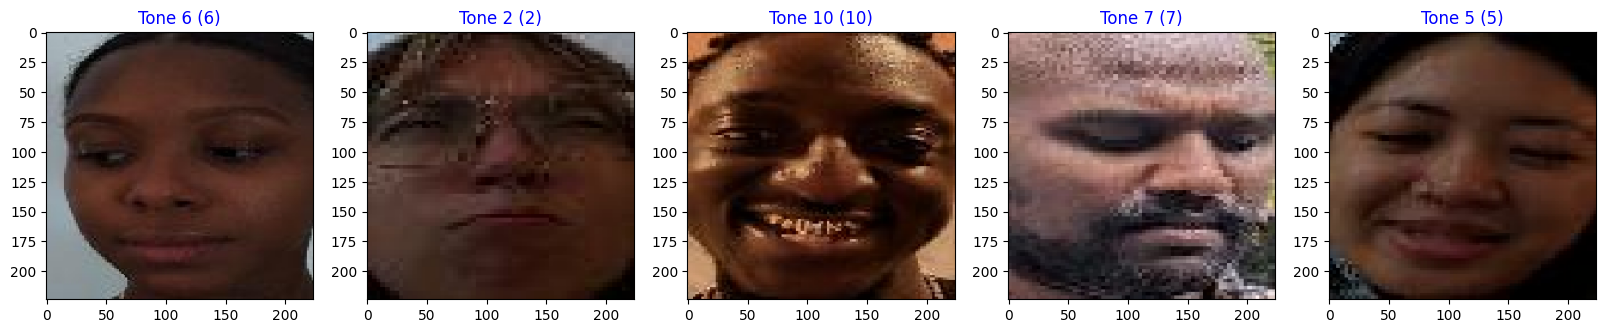

In [25]:
path = './dataset/mst_cropped/validation/'
path_list = get_sample(path)
viz_utils(path_list)